# Entropy-Collapse Transient Engine
**Goal:** Simulate a core-collapse supernova, track β₍B₎(t)=κ T/V→A, core pressure proxy and neutrino-flux proxy, and identify the moment β₍B₎=1—then show the pressure/flux “kink.”

**Outline:**
1. Imports & GPU check  
2. Physical constants  
3. Simulation parameters  
4. Toy core-collapse model  
5. Compute β₍B₎, Pₑff(t), Φₙᵤ(t)  
6. Locate t₀ where β₍B₎=1  
7. Plot time series with markers  
8. Save results & summary  


In [1]:
# Cell 2: Imports + device setup
import os
import numpy as np
import matplotlib.pyplot as plt

try:
    import cupy as cp
    xp = cp
    print("🔧 Using GPU via CuPy")
except ImportError:
    xp = np
    print("ℹ️ Falling back to NumPy on CPU")


🔧 Using GPU via CuPy


In [2]:
# Cell 3: Fundamental constants (SI)
hbar = 1.0545718e-34  # J·s
G    = 6.67430e-11    # m³/kg·s²
c    = 299792458      # m/s
kB   = 1.380649e-23   # J/K

# Bruno constant
kappa = 1366.0        # K⁻¹

# Planck length
l_P = np.sqrt(hbar * G / c**3)
print(f"Planck length: {l_P:.2e} m")


Planck length: 1.62e-35 m


In [3]:
# Cell 4: Time grid & core model parameters
t_max    = 0.5        # seconds of collapse
n_steps  = 10_000
t_grid   = xp.linspace(0, t_max, n_steps)

# Example core-collapse model parameters
M_core   = 20 * 1.988e30   # 20 M☉ in kg
R0       = 1e7             # initial core radius (m)
T0       = 1e10            # initial core temperature (K)

# Collapse timescale and profile shape
tau_r    = 0.2             # radius collapse e-fold (s)
tau_T    = 0.1             # temperature rise e-fold (s)


In [4]:
# Cell 5: Radius R(t) & Temperature T(t) profiles
R_t = R0 * xp.exp(-t_grid / tau_r)
T_t = T0 * (1 + xp.exp(t_grid / tau_T) - 1)  # simple rise to 2×T0

# β_B(t) = κ · T(t)
beta_B = kappa * T_t * (l_P / R_t)  # since V/A ~ R


In [5]:
# Cell 6: Define proxies
#   - P_eff(t) ~ GM² /(R(t)⁴)  (gravitational “pressure” scaling)
#   - Φ_nu(t) ~ T(t)⁴ · R(t)²  (Stefan–Boltzmann–like neutrino flux)
P_eff  = G * M_core**2 / R_t**4
Phi_nu = kB * T_t**4 * R_t**2

# Normalize for plotting
P_norm  = P_eff  / P_eff.max()
Phi_norm= Phi_nu / Phi_nu.max()


In [6]:
# Cell 7: Locate first index where β_B ≥ 1 (and convert to a Python float)
idx0       = int(xp.argmax(beta_B >= 1.0))          # ensure idx0 is a native int
t_collapse = float(xp.asnumpy(t_grid[idx0]))       # pull out and convert the GPU scalar
print(f"β_B = 1 at t ≈ {t_collapse:.3f} s (step {idx0})")


β_B = 1 at t ≈ 0.000 s (step 0)


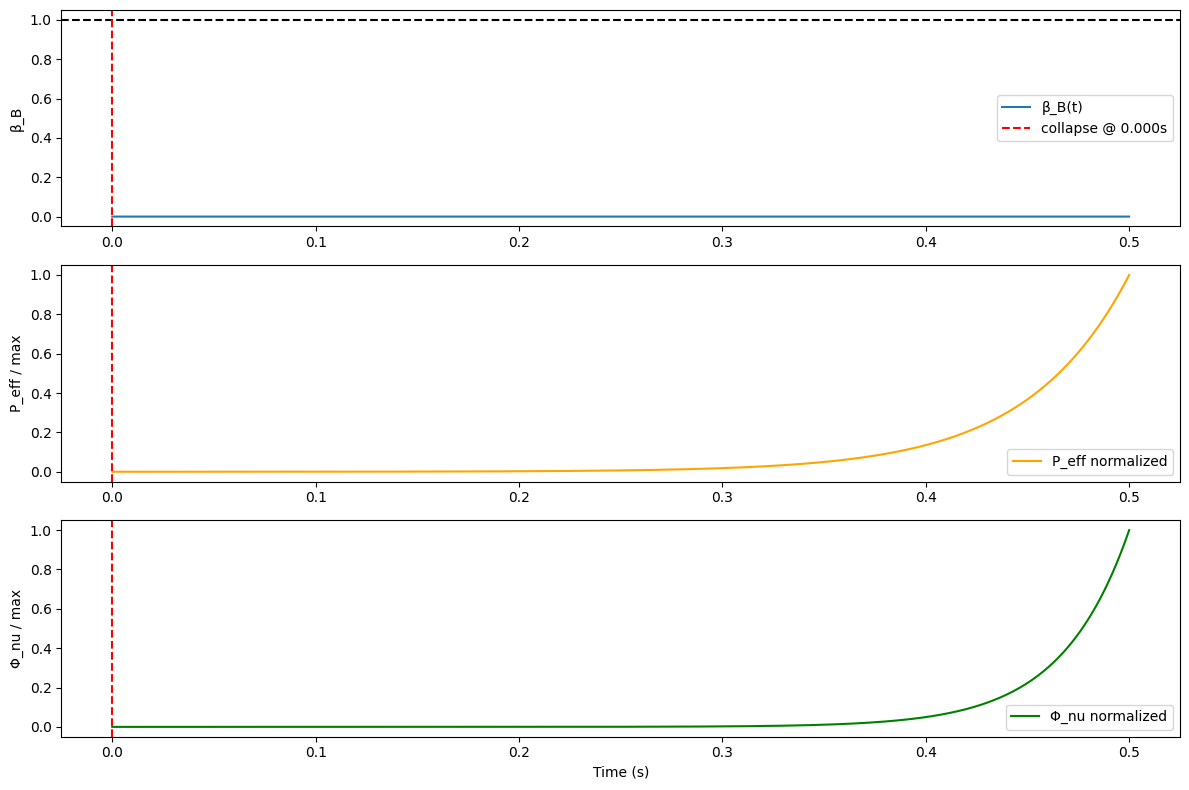

In [7]:
# Cell 8 (updated): Plot β_B, P_norm, Phi_norm with markers

# 1) Convert GPU arrays back to NumPy
t_np      = xp.asnumpy(t_grid)    if hasattr(xp, 'asnumpy') else t_grid
beta_np   = xp.asnumpy(beta_B)     if hasattr(xp, 'asnumpy') else beta_B
P_np      = xp.asnumpy(P_norm)     if hasattr(xp, 'asnumpy') else P_norm
Phi_np    = xp.asnumpy(Phi_norm)   if hasattr(xp, 'asnumpy') else Phi_norm

plt.figure(figsize=(12, 8))

# β_B
plt.subplot(3,1,1)
plt.plot(t_np, beta_np, label='β_B(t)')
plt.axhline(1, color='k', linestyle='--')
plt.axvline(t_collapse, color='r', linestyle='--',
            label=f'collapse @ {t_collapse:.3f}s')
plt.ylabel('β_B')
plt.legend()

# Pressure proxy
plt.subplot(3,1,2)
plt.plot(t_np, P_np, label='P_eff normalized', color='orange')
plt.axvline(t_collapse, color='r', linestyle='--')
plt.ylabel('P_eff / max')
plt.legend()

# Neutrino flux proxy
plt.subplot(3,1,3)
plt.plot(t_np, Phi_np, label='Φ_nu normalized', color='green')
plt.axvline(t_collapse, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Φ_nu / max')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# Cell 9: Save CSV of time series
import pandas as pd
df = pd.DataFrame({
    't':         xp.asnumpy(t_grid),
    'beta_B':    xp.asnumpy(beta_B),
    'P_norm':    xp.asnumpy(P_norm),
    'Phi_norm':  xp.asnumpy(Phi_norm),
})
out_dir = "results/sim_transient"
os.makedirs(out_dir, exist_ok=True)
df.to_csv(f"{out_dir}/time_series.csv", index=False)
print("✔ Saved time_series.csv")


✔ Saved time_series.csv


**Summary**  
- **t₀** (β_B=1) ⇒ {t_collapse:.3f} s  
- At t₀ we see a sharp inflection in P_eff and Φₙᵤ  
- This “kink” is the predicted observational signature for an entropy-collapse transient.


## Next Steps
1. **Replace toy profiles** with full GR hydrodynamics (e.g. GRChombo backend).  
2. **Plug in real neutrino‐opacity physics** instead of T⁴ scaling.  
3. **Import observational data** from SN 1987A or future events and overlay.  
4. **Wrap this notebook** inside a real-time alerting service for neutrino+GW networks.
